In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

!whoami
!date

alibow
Thu Jun 11 17:04:45 PDT 2020


In [2]:
output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/00_bugfix/lbwsg_change/india/2020_06_11_13_37_15/count_data/']

locations = ['India']

In [3]:
deaths = pd.read_hdf(output_dirs[0] + 'deaths.hdf')
deaths = deaths.groupby(['age_group','sex','input_draw','scenario']).sum()
deaths #note... identical death counts for each scenario

value
age_group      sex    input_draw scenario                                
1_to_4         female 602        baseline                            53.0
                                 folic_acid_fortification_scale_up   53.0
                                 vitamin_a_fortification_scale_up    53.0
               male   602        baseline                            45.0
                                 folic_acid_fortification_scale_up   45.0
                                 vitamin_a_fortification_scale_up    45.0
early_neonatal female 602        baseline                           118.0
                                 folic_acid_fortification_scale_up  118.0
                                 vitamin_a_fortification_scale_up   118.0
               male   602        baseline                           158.0
                                 folic_acid_fortification_scale_up  158.0
                                 vitamin_a_fortification_scale_up   158.0
late_neonatal  female 602        baseline                            32.0
                                 folic_acid_fortification_scale_up   32.0
                                 vitamin_a_fortification_scale_up    32.0
               male   602        baseline                            24.0
                                 folic_acid_fortification_scale_up   24.0
                                 vitamin_a_fortification_scale_up    24.0
post_neonatal  female 602        baseline                           105.0
                                 folic_acid_fortification_scale_up  105.0
                                 vitamin_a_fortification_scale_up   105.0
               male   602        baseline                            93.0
                                 folic_acid_fortification_scale_up   93.0
                                 vitamin_a_fortification_scale_up    93.0

In [4]:
pt = pd.read_hdf(output_dirs[0] + 'person_time.hdf')
pt = pt.groupby (['age_group','sex','input_draw','scenario']).sum()
pt

value
age_group      sex    input_draw scenario                                       
1_to_4         female 602        baseline                           33878.464314
                                 folic_acid_fortification_scale_up  33878.464314
                                 vitamin_a_fortification_scale_up   33878.464314
               male   602        baseline                           37241.632007
                                 folic_acid_fortification_scale_up  37241.632007
                                 vitamin_a_fortification_scale_up   37241.632007
early_neonatal female 602        baseline                             150.928250
                                 folic_acid_fortification_scale_up    150.928250
                                 vitamin_a_fortification_scale_up     150.928250
               male   602        baseline                             166.474836
                                 folic_acid_fortification_scale_up    166.474836
                                 vitamin_a_fortification_scale_up     166.474836
late_neonatal  female 602        baseline                             451.190682
                                 folic_acid_fortification_scale_up    451.190682
                                 vitamin_a_fortification_scale_up     451.190682
               male   602        baseline                             498.673052
                                 folic_acid_fortification_scale_up    498.673052
                                 vitamin_a_fortification_scale_up     498.673052
post_neonatal  female 602        baseline                            7164.552977
                                 folic_acid_fortification_scale_up   7164.552977
                                 vitamin_a_fortification_scale_up    7164.552977
               male   602        baseline                            7970.527512
                                 folic_acid_fortification_scale_up   7970.527512
                                 vitamin_a_fortification_scale_up    7970.527512

In [5]:
acmr = deaths / pt
acmr = acmr.reset_index().drop(columns='input_draw')
acmr = acmr.loc[acmr.scenario == 'baseline']
acmr['sex'] = np.where(acmr['sex'] == 'female', 'Female', 'Male')
acmr = acmr.set_index(['sex','age_group']).sort_index().reset_index()
acmr = acmr.where(acmr['age_group'].isin(['early_neonatal','late_neonatal'])).dropna()
acmr

,sex,age_group,scenario,value
1,Female,early_neonatal,baseline,0.781828
2,Female,late_neonatal,baseline,0.070923
5,Male,early_neonatal,baseline,0.949092
6,Male,late_neonatal,baseline,0.048128


In [6]:
art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/india.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
data = art.load('cause.all_causes.cause_specific_mortality_rate')
data_mean = pd.DataFrame(data.mean(axis=1)).rename(columns={0:'value'})
data_limits = pd.DataFrame(data.quantile([0.0,1], axis=1)).transpose().rename(columns={0.0:'lower',
                                                                                             1:'upper'})
data = data_mean.merge(data_limits, right_index=True, left_index=True).reset_index()
data['age_group'] = 0
data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                       np.where(data['age_end'] == 1, 'post_neonatal',
                                np.where(data['age_start'] == 1, '1_to_4', 
                                        'late_neonatal')))
data

,location,sex,age_start,age_end,year_start,year_end,value,lower,upper,age_group
0,India,Female,0.000000,0.019178,2017,2018,0.903030,0.826478,0.997342,early_neonatal
1,India,Female,0.019178,0.076712,2017,2018,0.093716,0.086097,0.102730,late_neonatal
2,India,Female,0.076712,1.000000,2017,2018,0.015371,0.014059,0.017052,post_neonatal
3,India,Female,1.000000,5.000000,2017,2018,0.001737,0.001436,0.002045,1_to_4
4,India,Male,0.000000,0.019178,2017,2018,1.012133,0.934420,1.107655,early_neonatal
5,India,Male,0.019178,0.076712,2017,2018,0.074361,0.068296,0.081276,late_neonatal
6,India,Male,0.076712,1.000000,2017,2018,0.012091,0.011133,0.013314,post_neonatal
7,India,Male,1.000000,5.000000,2017,2018,0.001322,0.001095,0.001559,1_to_4


In [7]:
data = data.set_index(['sex','age_group']).sort_index().reset_index()
data = data.where(data['age_group'].isin(['early_neonatal','late_neonatal'])).dropna()
data

,sex,age_group,location,age_start,age_end,year_start,year_end,value,lower,upper
1,Female,early_neonatal,India,0.000000,0.019178,2017.0,2018.0,0.903030,0.826478,0.997342
2,Female,late_neonatal,India,0.019178,0.076712,2017.0,2018.0,0.093716,0.086097,0.102730
5,Male,early_neonatal,India,0.000000,0.019178,2017.0,2018.0,1.012133,0.934420,1.107655
6,Male,late_neonatal,India,0.019178,0.076712,2017.0,2018.0,0.074361,0.068296,0.081276


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


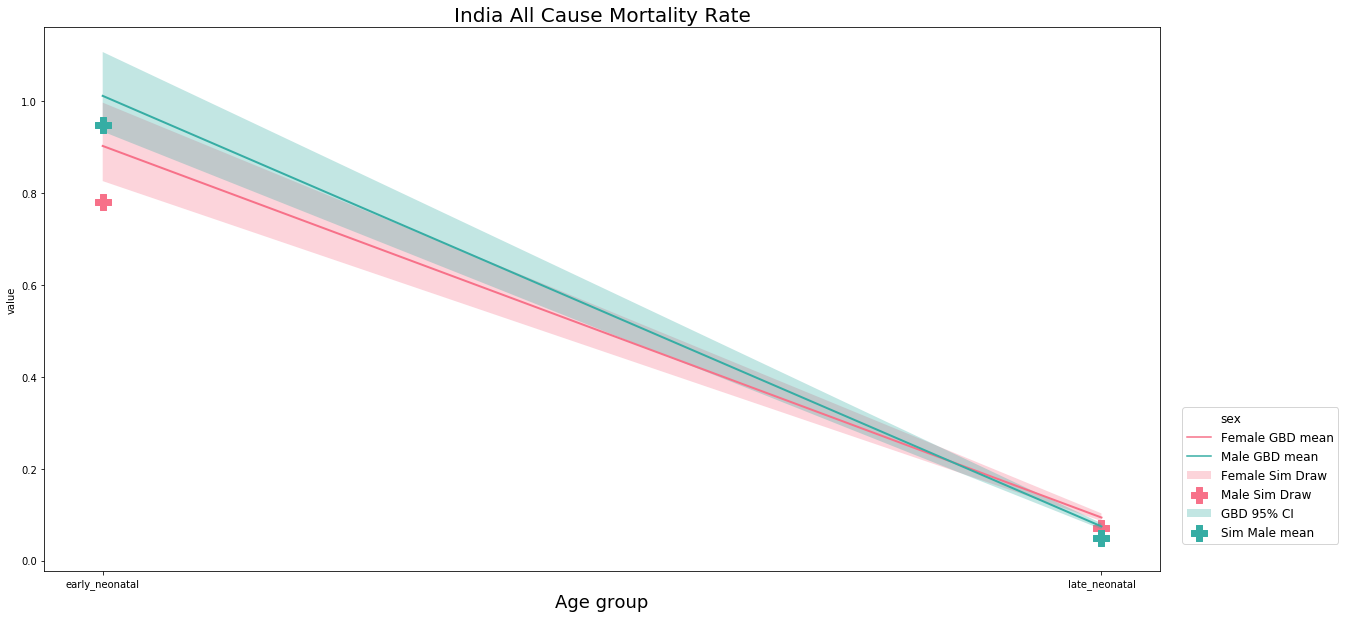

In [8]:
measure_m = acmr
measure_g = data

fig, ax = plt.subplots(figsize=(20, 10))
clrs = sns.color_palette('husl', 2)

sns.lineplot(x='age_group', y='value', hue='sex', palette=clrs, 
         linewidth=2, ax=ax, data=measure_g, sort=False)

for i, sex in enumerate(['Female','Male']):
    sex_g = measure_g.loc[measure_g.sex == sex]
    ax.fill_between(sex_g.age_group.values, sex_g.upper, sex_g.lower, alpha=0.3, label='GBD 95% CI', facecolor=clrs[i])

    sex_m = measure_m.loc[measure_m.sex == sex]
    ax.scatter(sex_m.age_group, sex_m.value, s=250, marker='P', 
           label=f'Sim {sex} mean', c=clrs[i])

ax.set_title('India All Cause Mortality Rate', fontsize=20)
ax.set_xlabel('Age group', fontsize=18)

l = ax.legend(loc=(1.02, 0.05), fontsize=12)
labels = ['Female GBD mean','Male GBD mean','Female Sim Draw','Male Sim Draw']
for text, label in zip(l.texts[1:5], labels):
    text.set_text(label)